In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MyProblem():
    def __init__(self):
        super().__init__()
        self.cost = 0
        self.deflection = 0
        self.g1 = 0
        self.g2 = 0
        self.g3 = 0
        self.g4 = 0
        
        self.tau_dash = 0
        self.tau_dash2 = 0
        self.tau = 0
        self.sigma = 0
        self.pc = 0
    
    def evaluate(self, x): 
        #x:parameters
        
        self.cost = 1.10471 * x[0]**2 * x[1] + 0.04811*x[2]*x[3]*(14.0+x[1])
        self.deflection = 2.1952/ x[2]**3 / x[3]
        
        self.tau_dash = 6000/torch.sqrt(torch.tensor(2.0))/x[0]/x[1]
        self.tau_dash2 = 6000*(14+0.5*x[1])*torch.sqrt(0.25*(x[1]**2+(x[0]+x[2])**2))  /  (2*0.707*x[0]*x[1]*(x[1]**2/12+0.25*(x[1]**2+(x[0]+x[2])**2)))
        self.tau =torch.sqrt(self.tau_dash**2 + self.tau_dash2**2 + x[1]*self.tau_dash*self.tau_dash2 / torch.sqrt(0.25*(x[1]**2+(x[0]+x[2])**2)))
        
        self.sigma = 504000/x[2]**2/x[3]
        self.pc = 64764.022*(1-0.0282346*x[2])*x[2]*x[3]**3
        
        self.g1 = self.tau-13600
        self.g2 = self.sigma-30000
        self.g3 = x[0]-x[3]
        self.g4 = 6000-self.pc
        
    
    def calc_loss(self, w):
        #w:weight
        return w*self.cost + (1-w)*self.deflection*1000 #だいたいオーダーをそろえるために1000倍した
    
    def print_f1(self):
        print(self.f1)

In [3]:
problem = MyProblem()

## Adamによる最適化

In [4]:
lower = np.array([0.125,0.1,0,0]) #lower
upper = np.array([10,10,10,5]) #upper

In [5]:
losses = []
#weights = [0.1, 0.2, 0.3, 0.4, 0.5]
costs = []
deflections = []
x_es = np.zeros(4)

w = 0.01

for n in range(100):
    problem = MyProblem()
    x = torch.tensor([1.0,1.0,1.0,1.0], requires_grad=True, device='cuda')
    optimizer = optim.Adam([x])
    loss_n  =[]
    
    for i in range(30000):
        optimizer.zero_grad()
        problem.evaluate(x)
        loss = problem.calc_loss(w)
        loss.backward()
        optimizer.step()
        loss_n.append(loss)
    
        with torch.no_grad(): #不等式制約
            for j in range(len(lower)):
                x[j].clamp_(lower[j],upper[j])

    costs.append(problem.cost.to('cpu').detach().numpy().copy())
    deflections.append(problem.deflection.to('cpu').detach().numpy().copy())
    losses.append(loss_n)
    x_np = x.to('cpu').detach().numpy().copy()
    x_es = np.vstack([x_es,x_np])
        
    print(w, x_np)
    
    w = w + 0.01

0.01 [ 0.125  0.1   10.     5.   ]
0.02 [ 0.125      0.1       10.         3.9820623]
0.03 [ 0.125      0.1       10.         3.2347088]
0.04 [ 0.125      0.1       10.         2.7868624]
0.05 [ 0.125      0.1       10.         2.4796288]
0.060000000000000005 [ 0.125     0.1      10.        2.251636]
0.07 [ 0.125      0.1       10.         2.0734918]
0.08 [ 0.125      0.1       10.         1.9291178]
0.09 [ 0.125     0.1      10.        1.808878]
0.09999999999999999 [ 0.125      0.1       10.         1.7065973]
0.10999999999999999 [ 0.125      0.1       10.         1.6181116]
0.11999999999999998 [ 0.125      0.1       10.         1.5404959]
0.12999999999999998 [ 0.125      0.1       10.         1.4716271]
0.13999999999999999 [ 0.125      0.1       10.         1.4099219]
0.15 [ 0.125      0.1       10.         1.3541714]
0.16 [ 0.125      0.1       10.         1.3034353]
0.17 [ 0.125      0.1       10.         1.2569685]
0.18000000000000002 [ 0.125      0.1       10.         1.2141727]


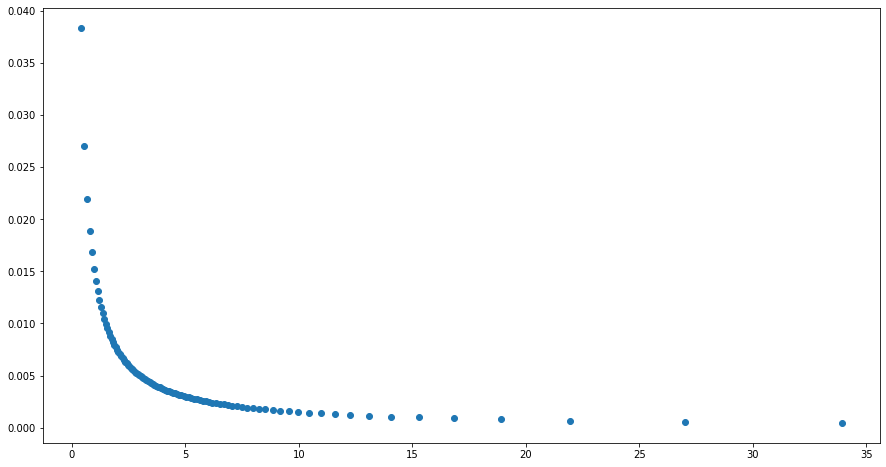

In [12]:
plt.figure(figsize=(15,8))
plt.scatter(costs,deflections)

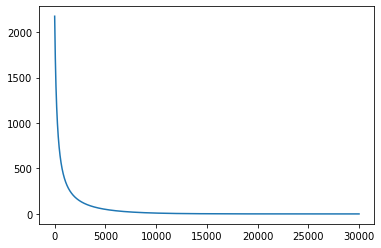

In [19]:
plt.plot(losses[0])

In [21]:
x_es.shape

(101, 4)

In [ ]:
import matplotlib.pyplot as plt
xl, xu = problem.bounds()
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.scatter(e_es[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
ax1.set_xlim(xl[0], 10)
ax1.set_ylim(xl[1], 100)
ax1.set_title("Design Space 1-2")

ax2.scatter(X[:, 1], X[:, 2], s=30, facecolors='none', edgecolors='r')
ax2.set_xlim(xl[1], 100)
ax2.set_ylim(xl[2], xu[2])
ax2.set_title("Design Space 2-3")

ax3.scatter(X[:, 2], X[:, 3], s=30, facecolors='none', edgecolors='r')
ax3.set_xlim(xl[2], xu[2])
ax3.set_ylim(xl[3], xu[3])
ax3.set_title("Design Space 3-4")

ax4.scatter(X[:, 3], X[:, 0], s=30, facecolors='none', edgecolors='r')
ax4.set_xlim(xl[3], xu[3])
ax4.set_ylim(xl[0], 10)
ax4.set_title("Design Space 4-1")

fig.show()
